In [1]:
import sys
sys.path.append('../..')

In [2]:
import sbi4abm.sbi
from sbi4abm.sbi import analysis, utils
from sbi4abm.utils import sampling, plotting
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import pickle
import seaborn as sns
from torch.nn import functional as F

/home/pmms2/sbi4abm/py_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
matplotlib.rc('text', usetex=True)
plt.rcParams.update({
  "text.usetex": False,
  "font.family": "serif"
})
plt.rcParams.update({
    'text.latex.preamble':r"\usepackage{amsmath}"+"\n"+r"\usepackage{bm}"
})

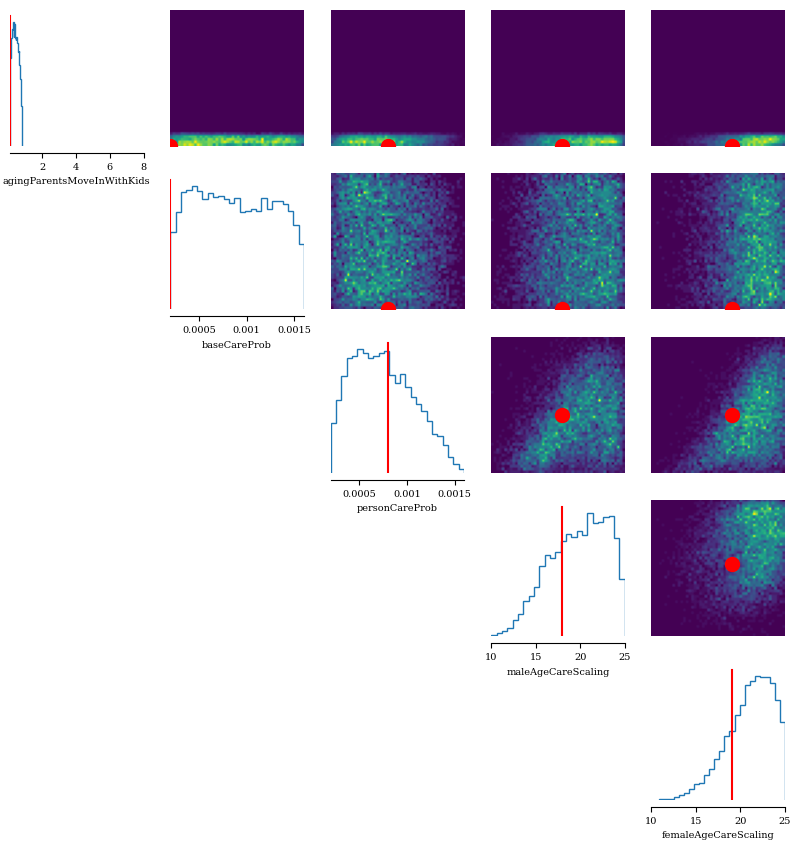

In [4]:
# maf_s (new arch) 10,000 samples
socialcare = np.loadtxt("../../exp_dir/socialcare/1715151754.033255/samples.txt")
plt.rcParams.update({'font.size':7}) # something about latex font
_ = analysis.pairplot(socialcare, limits=[[0.1,8], [0.0002, 0.0016], [0.0002, 0.0016], [10, 25], [10, 25]], 
                      points=[np.array([0.1, 0.0002, 0.0008, 18.0, 19.0])],
                      points_colors='r', labels=["agingParentsMoveInWithKids", "baseCareProb", "personCareProb", 
                                                 "maleAgeCareScaling", "femaleAgeCareScaling"],
                      hist_diag={"alpha": 1.0, "bins": 25, "density": False, "histtype": "step"})

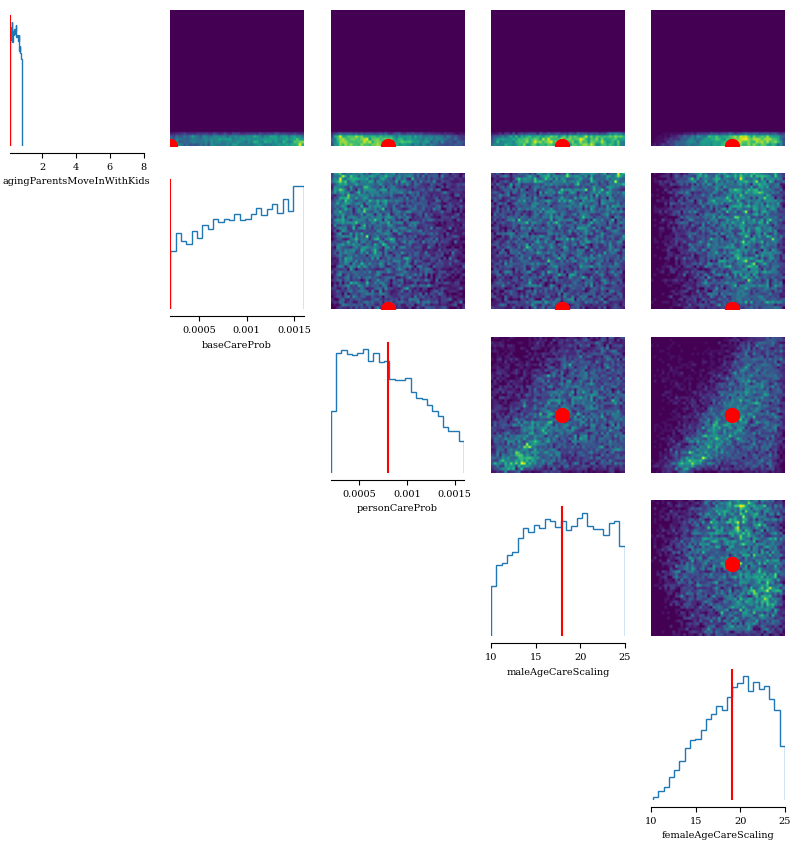

In [49]:
# maf_s (new arch) 100,000 samples
socialcare = np.loadtxt("../../exp_dir/socialcare/1715158835.9513047/samples.txt")
plt.rcParams.update({'font.size':7}) # something about latex font
_ = analysis.pairplot(socialcare, limits=[[0.1,8], [0.0002, 0.0016], [0.0002, 0.0016], [10, 25], [10, 25]], 
                      points=[np.array([0.1, 0.0002, 0.0008, 18.0, 19.0])],
                      points_colors='r', labels=["agingParentsMoveInWithKids", "baseCareProb", "personCareProb", 
                                                 "maleAgeCareScaling", "femaleAgeCareScaling"],
                      hist_diag={"alpha": 1.0, "bins": 25, "density": False, "histtype": "step"})

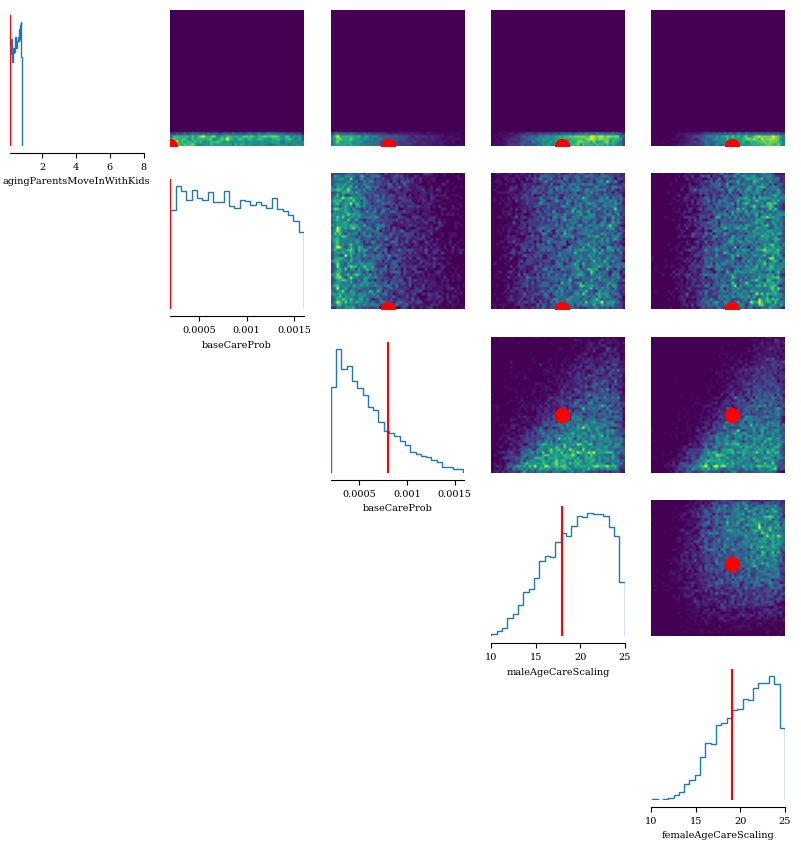

In [4]:
# maf_s (final new arch) 100,000 samples
socialcare = np.loadtxt("../../exp_dir/socialcare/1715970743.439267/samples.txt")
plt.rcParams.update({'font.size':7}) # something about latex font
_ = analysis.pairplot(socialcare, limits=[[0.1,8], [0.0002, 0.0016], [0.0002, 0.0016], [10, 25], [10, 25]], 
                      points=[np.array([0.1, 0.0002, 0.0008, 18.0, 19.0])],
                      points_colors='r', labels=["agingParentsMoveInWithKids", "baseCareProb", "baseCareProb", 
                                                 "maleAgeCareScaling", "femaleAgeCareScaling"],
                      hist_diag={"alpha": 1.0, "bins": 25, "density": False, "histtype": "step"})

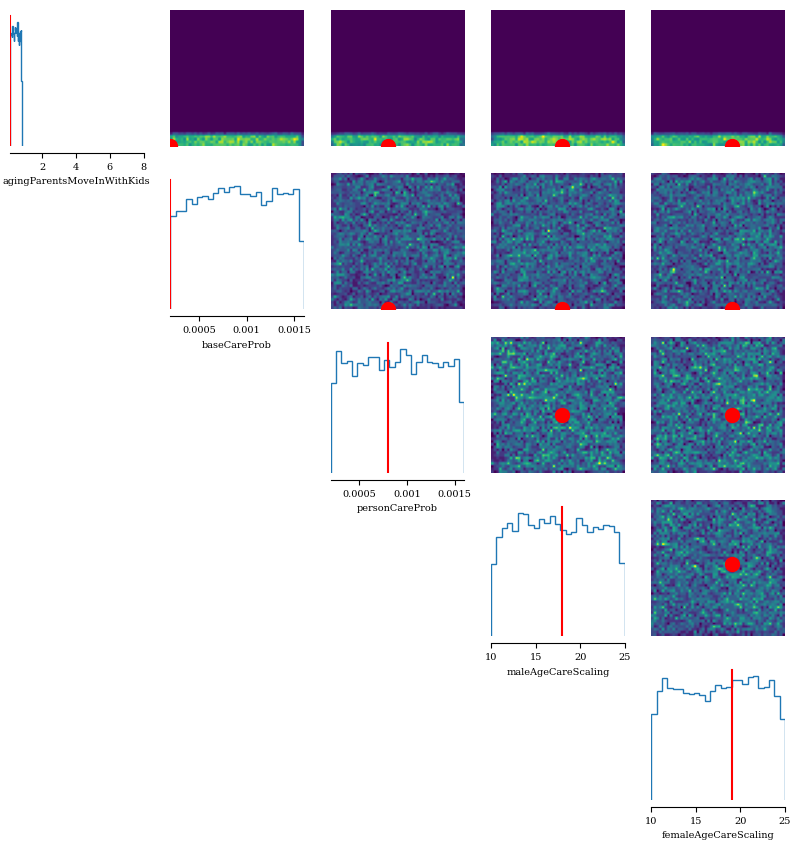

In [7]:
# maf_s (final new arch) 100,000 samples -> using final tax only
socialcare = np.loadtxt("../../exp_dir/socialcare/1716121654.4654644/samples.txt")
plt.rcParams.update({'font.size':7}) # something about latex font
_ = analysis.pairplot(socialcare, limits=[[0.1,8], [0.0002, 0.0016], [0.0002, 0.0016], [10, 25], [10, 25]], 
                      points=[np.array([0.1, 0.0002, 0.0008, 18.0, 19.0])],
                      points_colors='r', labels=["agingParentsMoveInWithKids", "baseCareProb", "personCareProb", 
                                                 "maleAgeCareScaling", "femaleAgeCareScaling"],
                      hist_diag={"alpha": 1.0, "bins": 25, "density": False, "histtype": "step"})

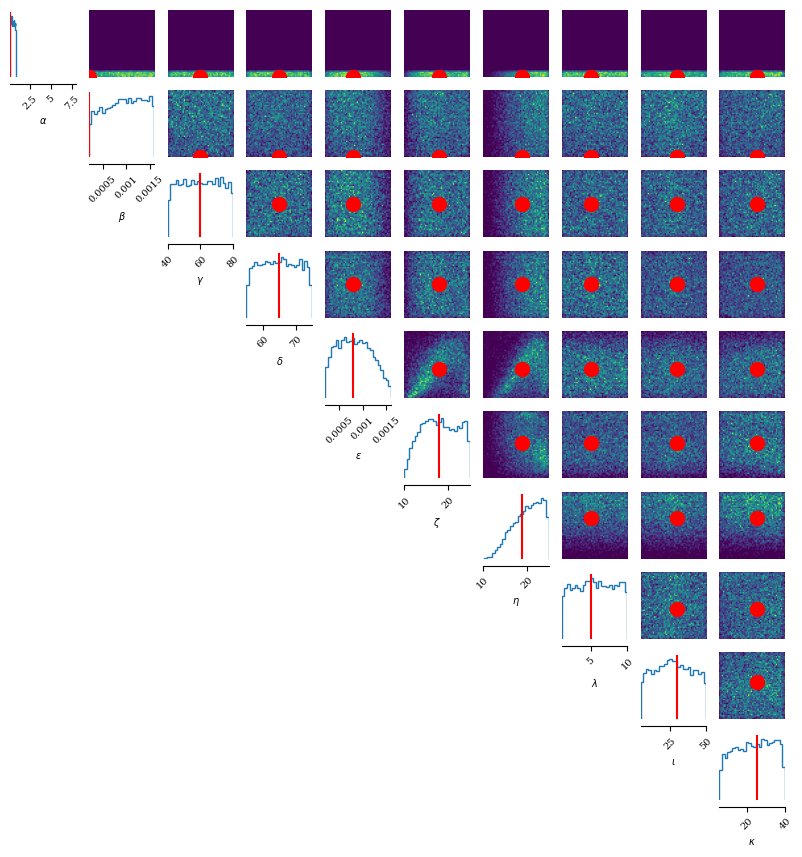

In [4]:
# maf_s (old arch) 100,000 samples
socialcare = np.loadtxt("../../exp_dir/socialcare/1716637307.9780319/samples.txt")
plt.rcParams.update({'font.size':7}) # something about latex font
g = analysis.pairplot(socialcare, limits=[[0.1,8], [0.0002, 0.0016], [40,80], [55, 75], [0.0002, 0.0016], [10, 25], [10, 25], [1, 10], [5, 50], [5, 40]], 
                      points=[np.array([0.1, 0.0002, 60.0, 65, 0.0008, 18.0, 19.0, 5.0, 30.0, 25.0])],
                      points_colors='r', labels=[r"$\alpha$", r"$\beta$", r"$\gamma$", 
                                                 r"$\delta$", r"$\epsilon$", r"$\zeta$", r"$\eta$", 
                                                 r"$\lambda$", r"$\iota$", r"$\kappa$"], 
                      hist_diag={"alpha": 1.0, "bins": 25, "density": False, "histtype": "step"})

# Rotate the labels
# Rotate the labels on all subplots
# g[1] is the 2D numpy array of Axes objects
for row in g[1]:
    for ax in row:
        # Rotate the xticklabels
        plt.setp(ax.get_xticklabels(), rotation=45)
        # Rotate the yticklabels
        plt.setp(ax.get_yticklabels(), rotation=45)

# MAP

In [5]:
from sbi4abm.utils import io

socialcaref = io.load_task('socialcare')

file_name = "1716637307.9780319"
with open(f"../../exp_dir/socialcare/{file_name}/posteriors.pkl", 'rb') as file:
    posterior = pickle.load(file)
    posterior = posterior[0]

In [6]:
# Define the negative log-posterior function for minimization
def neg_log_posterior(theta, posterior, observed_data):
    theta = torch.tensor(theta).float()
    return -posterior.log_prob(theta, x=observed_data).item()

In [9]:
from scipy.optimize import minimize

# observed data
final = socialcaref[2]
observation_tax = final[0]
observation_tax_years_average = final[1]
observations = torch.tensor([observation_tax, observation_tax_years_average])

initial_theta = socialcaref[1].mean.numpy()

# Optimize to find the MAP estimate
result = minimize(neg_log_posterior, initial_theta, args=(posterior, observations), method='L-BFGS-B')
map_estimate = result.x

print(f"MAP estimate: {map_estimate}")


MAP estimate: [4.50000018e-01 8.99999985e-04 8.99999985e-04 1.75000000e+01
 1.75000000e+01]


In [10]:
true_theta = torch.tensor(socialcaref[3])
map_estimate = torch.tensor(map_estimate)
print(true_theta)
print(map_estimate)
loss = F.mse_loss(map_estimate, true_theta)
print(f"Loss between MAP theta and true theta: {loss.item()}")

tensor([1.0000e-01, 2.0000e-04, 8.0000e-04, 1.8000e+01, 1.9000e+01],
       dtype=torch.float64)
tensor([4.5000e-01, 9.0000e-04, 9.0000e-04, 1.7500e+01, 1.7500e+01],
       dtype=torch.float64)
Loss between MAP theta and true theta: 0.5245001025033902


In [11]:
y_star = socialcaref[0](map_estimate.tolist())
y_star = torch.tensor([y_star[0], y_star[1]])
print(y_star)


[0.45000001788139343, 0.0008999999845400453, 0.0008999999845400453, 17.5, 17.5]
tensor([11366.0146,  9005.2510])


In [12]:
import torch.nn.functional as F

def loss_function(simulated_output, observed_statistic):
    return F.mse_loss(simulated_output, observed_statistic)


# Compute the loss
loss = loss_function(y_star, observations)

print(f"Loss: {loss.item()}")

Loss: 15506937.902151


In [13]:
def loss_function(simulated_output, observed_statistic):
    return F.mse_loss(simulated_output, observed_statistic)

# Number of simulations
num_simulations = 10

# List to store the losses of each simulation
losses = []

for i in range(num_simulations):
    # Run the simulation and get the simulated output
    # Note: You need to replace this with your actual simulation code
    y_star = socialcaref[0](map_estimate.tolist())
    y_star = torch.tensor([y_star[0], y_star[1]])

    # Compute the loss
    loss = loss_function(y_star, observations)

    # Add the loss to the list of losses
    losses.append(loss.item())

# Compute the average loss
average_loss = sum(losses) / num_simulations

print(f"Average Loss: {average_loss}")

[0.45000001788139343, 0.0008999999845400453, 0.0008999999845400453, 17.5, 17.5]
[0.45000001788139343, 0.0008999999845400453, 0.0008999999845400453, 17.5, 17.5]
[0.45000001788139343, 0.0008999999845400453, 0.0008999999845400453, 17.5, 17.5]
[0.45000001788139343, 0.0008999999845400453, 0.0008999999845400453, 17.5, 17.5]
[0.45000001788139343, 0.0008999999845400453, 0.0008999999845400453, 17.5, 17.5]
[0.45000001788139343, 0.0008999999845400453, 0.0008999999845400453, 17.5, 17.5]
[0.45000001788139343, 0.0008999999845400453, 0.0008999999845400453, 17.5, 17.5]
[0.45000001788139343, 0.0008999999845400453, 0.0008999999845400453, 17.5, 17.5]
[0.45000001788139343, 0.0008999999845400453, 0.0008999999845400453, 17.5, 17.5]
[0.45000001788139343, 0.0008999999845400453, 0.0008999999845400453, 17.5, 17.5]
Average Loss: 11898365.632052489


# Mean

In [6]:
# # Generate samples from the posterior
# num_samples = 1000  # Number of samples to draw
# posterior_samples = posterior.sample((num_samples,), x=observations)

# # Compute the mean of the samples
# mean_estimate = posterior_samples.mean(dim=0)
mean_estimate = np.mean(socialcare, axis=0)
print(f"Mean estimate: {mean_estimate}")

Mean estimate: [4.47545327e-01 9.39477080e-04 6.01229685e+01 6.49934523e+01
 8.26531288e-04 1.80472685e+01 2.00432095e+01 5.54689693e+00
 2.73932933e+01 2.31896505e+01]


In [17]:
# Compute statistics about the sampled theta values
posterior_samples_np = posterior_samples.numpy()
mean_theta = np.mean(posterior_samples_np, axis=0)
std_theta = np.std(posterior_samples_np, axis=0)
lower_bound_theta = np.percentile(posterior_samples_np, 2.5, axis=0)
upper_bound_theta = np.percentile(posterior_samples_np, 97.5, axis=0)

print(f"Mean of theta: {mean_theta}")
print(f"Standard deviation of theta: {std_theta}")
print(f"95% credible interval for theta: [{lower_bound_theta}, {upper_bound_theta}]")

Mean of theta: [4.5018810e-01 9.2624064e-04 5.9492229e+01 6.5161140e+01 8.1885932e-04
 1.7854185e+01 1.9936222e+01 5.5065551e+00 2.7097309e+01 2.3587944e+01]
Standard deviation of theta: [1.94708481e-01 4.00314486e-04 1.14590845e+01 5.41138315e+00
 3.50888236e-04 3.90272403e+00 3.22749496e+00 2.50273371e+00
 1.22314196e+01 9.43085003e+00]
95% credible interval for theta: [[1.39606678e-01 2.45842879e-04 4.14295972e+01 5.60539364e+01
 2.45705052e-04 1.11581141e+01 1.32439698e+01 1.35397681e+00
 6.18999985e+00 6.80731496e+00], [7.75281467e-01 1.55477464e-03 7.84759760e+01 7.42149492e+01
 1.48174170e-03 2.44303149e+01 2.46560277e+01 9.71436369e+00
 4.87227061e+01 3.86503223e+01]]


In [ ]:
true_theta = torch.tensor(socialcaref[3])
mean_theta = torch.tensor(mean_estimate)
print(true_theta)
print(mean_theta)
loss = F.mse_loss(mean_theta, true_theta)
print(f"Loss between mean theta and true theta: {loss.item()}")

In [17]:
y_star = socialcaref[0](mean_estimate.tolist())
y_star = torch.tensor([y_star[0], y_star[1]])
print(y_star)

[0.4652761875912547, 0.0008729207853204571, 0.0005913504386335262, 19.5245932308197, 20.48967496175766]
tensor([3233.4985, 3689.4968])


In [18]:
def loss_function(simulated_output, observed_statistic):
    return F.mse_loss(simulated_output, observed_statistic)


# Compute the loss
loss = loss_function(y_star, observations)

print(f"Loss: {loss.item()}")

Loss: 8597567.772134861


In [19]:
def loss_function(simulated_output, observed_statistic):
    return F.mse_loss(simulated_output, observed_statistic)

# Number of simulations
num_simulations = 10

# List to store the losses of each simulation
losses = []

for i in range(num_simulations):
    # Run the simulation and get the simulated output
    # Note: You need to replace this with your actual simulation code
    y_star = socialcaref[0](mean_estimate.tolist())
    y_star = torch.tensor([y_star[0], y_star[1]])

    # Compute the loss
    loss = loss_function(y_star, observations)

    # Add the loss to the list of losses
    losses.append(loss.item())

# Compute the average loss
average_loss = sum(losses) / num_simulations

print(f"Average Loss: {average_loss}")

[0.4652761875912547, 0.0008729207853204571, 0.0005913504386335262, 19.5245932308197, 20.48967496175766]
[0.4652761875912547, 0.0008729207853204571, 0.0005913504386335262, 19.5245932308197, 20.48967496175766]
[0.4652761875912547, 0.0008729207853204571, 0.0005913504386335262, 19.5245932308197, 20.48967496175766]
[0.4652761875912547, 0.0008729207853204571, 0.0005913504386335262, 19.5245932308197, 20.48967496175766]
[0.4652761875912547, 0.0008729207853204571, 0.0005913504386335262, 19.5245932308197, 20.48967496175766]
[0.4652761875912547, 0.0008729207853204571, 0.0005913504386335262, 19.5245932308197, 20.48967496175766]
[0.4652761875912547, 0.0008729207853204571, 0.0005913504386335262, 19.5245932308197, 20.48967496175766]
[0.4652761875912547, 0.0008729207853204571, 0.0005913504386335262, 19.5245932308197, 20.48967496175766]
[0.4652761875912547, 0.0008729207853204571, 0.0005913504386335262, 19.5245932308197, 20.48967496175766]
[0.4652761875912547, 0.0008729207853204571, 0.000591350438633526

# Posterior Predictive Checks 

In [5]:
from sbi4abm.utils import io

socialcaref = io.load_task('socialcare')

In [6]:
idxs = np.random.randint(socialcare.shape[0], size=1000)

### Posterior Predictives

In [7]:
pps = []
for idx in idxs:
    data = socialcaref[0](list(socialcare[idx]))
    pps.append(data)

[0.18114042282104492, 0.0005452191107906401, 0.00029904575785622, 17.11130142211914, 16.675458908081055]
[0.4775736927986145, 0.000801801506895572, 0.0007159470696933568, 20.328189849853516, 17.5156192779541]
[0.7183171510696411, 0.0008182831224985421, 0.0007662838906981051, 22.49689483642578, 19.932340621948242]
[0.644104540348053, 0.0014549207407981157, 0.0002362604282097891, 18.982254028320312, 20.879802703857422]
[0.2957129180431366, 0.0006207754486240447, 0.0006946826470084488, 21.692094802856445, 22.98291778564453]
[0.21174003183841705, 0.0010228920727968216, 0.0004457572940737009, 18.97172737121582, 20.43271827697754]
[0.5713632106781006, 0.0014829791616648436, 0.00121084856800735, 19.33130645751953, 20.768800735473633]
[0.6473293304443359, 0.0005608273786492646, 0.0006068287184461951, 21.169740676879883, 18.658397674560547]
[0.15800274908542633, 0.00046514111454598606, 0.000836402119603008, 18.428956985473633, 19.43325424194336]
[0.6241508722305298, 0.00030485313618555665, 0.00

In [8]:
posterior_tax = []
posterior_per_capita_cost = []

for pp in pps:
    posterior_tax.append(pp[0])
    posterior_per_capita_cost.append(pp[1])


### Prior Predictives

In [9]:
pps_ = []
for idx in idxs:
    data = socialcaref[0](list(socialcaref[1].sample().tolist()))
    pps_.append(data)

[0.26738134026527405, 0.0012598291505128145, 0.0008091370109468699, 21.560461044311523, 22.447837829589844]
[0.10444765537977219, 0.0007772210519760847, 0.000335405464284122, 22.798614501953125, 22.313892364501953]
[0.6172921657562256, 0.0014186474727466702, 0.0014114463701844215, 21.903335571289062, 13.710298538208008]
[0.575634777545929, 0.0014986260794103146, 0.00036749057471752167, 23.321754455566406, 24.094318389892578]
[0.7231404781341553, 0.0005903601995669305, 0.0007683865842409432, 21.06024932861328, 12.039536476135254]


[0.5390474796295166, 0.0010026488453149796, 0.0012133198324590921, 16.316913604736328, 16.567211151123047]
[0.590031623840332, 0.0009079365991055965, 0.000803296163212508, 16.46278953552246, 15.425287246704102]
[0.11445798724889755, 0.0014726868830621243, 0.0009571658447384834, 14.614362716674805, 10.541196823120117]
[0.2720465362071991, 0.00048294663429260254, 0.000603779568336904, 11.659948348999023, 19.137514114379883]
[0.5552052855491638, 0.001555717084556818, 0.0013050365960225463, 19.597652435302734, 17.1389102935791]
[0.36830970644950867, 0.001209334353916347, 0.00034650060115382075, 16.054866790771484, 14.388101577758789]
[0.6955786347389221, 0.0015821255510672927, 0.00024701165966689587, 23.044879913330078, 12.541089057922363]
[0.21483202278614044, 0.00043927691876888275, 0.0015390662010759115, 16.085344314575195, 17.33908462524414]
[0.6069298386573792, 0.001427850453183055, 0.0007633603527210653, 14.508383750915527, 16.360706329345703]
[0.47227731347084045, 0.0010471476707607

In [10]:
prior_tax = []
prior_per_capita_cost = []

for pp in pps_:
    prior_tax.append(pp[0])
    prior_per_capita_cost.append(pp[1])


### Observation

In [11]:
final = socialcaref[2]
observation_tax = final[0]
observation_per_capita_cost = final[1]
print(observation_tax)

6704.694763670065


### Plots

In [12]:
from matplotlib.lines import Line2D
import matplotlib.patches as patches

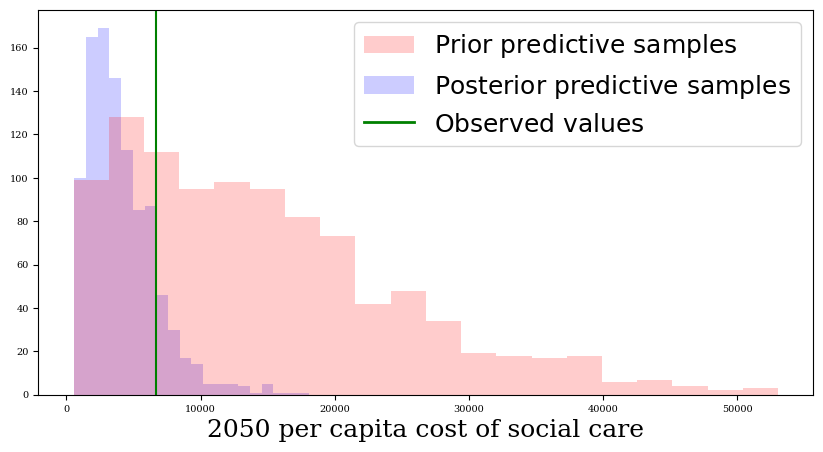

In [13]:
plt.figure(figsize=(10, 5))
plt.hist(posterior_tax, bins=20, color='b', alpha=0.2)
plt.hist(prior_tax, bins=20, color='r', alpha=0.2)
plt.axvline(observation_tax, c='g')
plt.xlabel(r"2050 per capita cost of social care", fontsize=18)
# plt.legend([r"Observed value", r"Prior predictive samples", r"Posterior predictive samples"], fontsize=18)

handles = [patches.Rectangle((0,0),0,0,facecolor='r',
                             label=r"${\rm Prior}$ ${\rm predictive}$ ${\rm samples}$", alpha=0.2),
           patches.Rectangle((0,0),0,0,facecolor='b',
                             label=r"${\rm Posterior}$ ${\rm predictive}$ ${\rm samples}$", alpha=0.2),
           Line2D([0], [0], color='g', label=r"${\rm Observed}$ ${\rm values}$", lw=2, linestyle="-")]

plt.legend(handles=handles, fontsize=18)

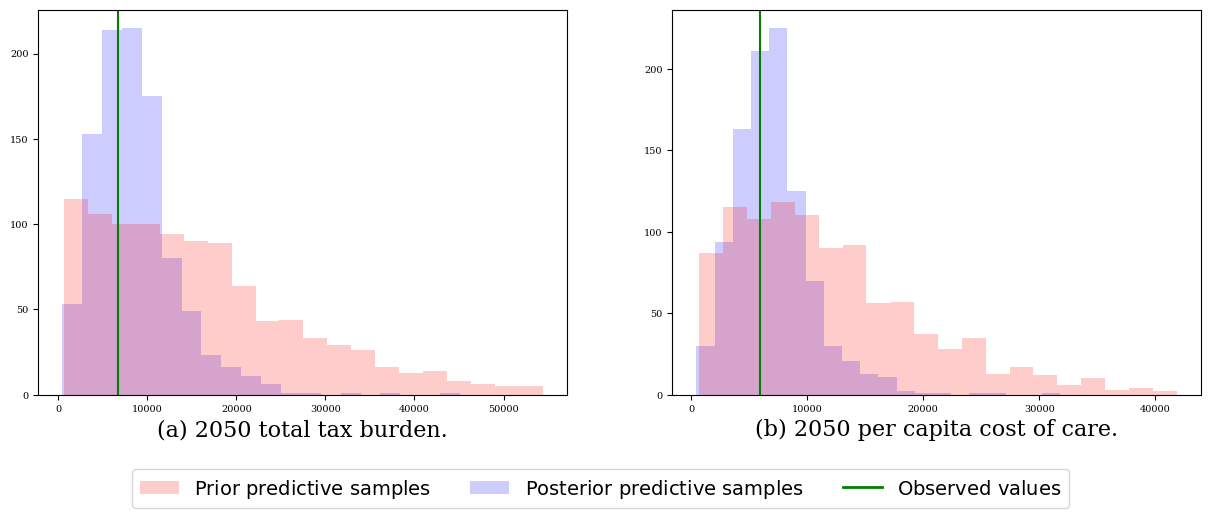

In [79]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(posterior_tax, bins=20, color='b', alpha=0.2)
axes[0].hist(prior_tax, bins=20, color='r', alpha=0.2)
axes[0].axvline(observation_tax, c='g')
axes[0].set_xlabel(r"(a) 2050 total tax burden.", fontsize=16)

axes[1].hist(posterior_per_capita_cost, bins=20, color='b', alpha=0.2)
axes[1].hist(prior_per_capita_cost, bins=20, color='r', alpha=0.2)
axes[1].axvline(observation_per_capita_cost, c='g')
axes[1].set_xlabel(r"(b) 2050 per capita cost of care.", fontsize=16)

handles = [patches.Rectangle((0,0),0,0,facecolor='r',
                             label=r"${\rm Prior}$ ${\rm predictive}$ ${\rm samples}$", alpha=0.2),
           patches.Rectangle((0,0),0,0,facecolor='b',
                             label=r"${\rm Posterior}$ ${\rm predictive}$ ${\rm samples}$", alpha=0.2),
           Line2D([0], [0], color='g', label=r"${\rm Observed}$ ${\rm values}$", lw=2, linestyle="-")]

# fig.legend(handles=handles, loc='lower center', ncol=3, fontsize=18)
fig.legend(handles=handles, bbox_to_anchor=(0.5, -0.02), loc='upper center', ncol=3, fontsize=14)

# plt.savefig("./overleaf_plots/graph_posterior_predictives.png", dpi=1000, format='png', bbox_inches='tight')